# Redes Neuronales Convolucionales

En este *script* revisaremos implementaciones básicas de redes convolucionales sencillas en Keras para resolver problemas de clasificación de imágenes no tan difíciles. Este *script* se basa en el de Francois Chollet, creador de Keras: https://keras.io/examples/vision/mnist_convnet/. Primero cargaremos las librerías adecuadas.

In [26]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2
from keras import layers


Vamos a resolver el problema de clasificación de imágenes MNIST, el cual cuanta con 10 clases de imágenes de 28 x 28. Tenemos que añadir una dimensión para usar nuestra red. Luego cargamos el *dataset*.

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Mostraremos el primer dato del conjunto de datos. Vemos que corresponde a la imagen de un número 5.

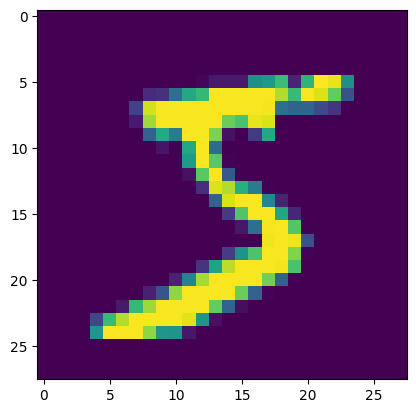

In [3]:
plt.imshow(X_train[0])

Al imprimir valor de la etiqueta, efectivamente corresponde a un 5.

In [4]:
print(y_train[0])

5


Las imágenes son tensores que tienen dimensión 28 $\times$ 28 y los valores varían de 0 a 255, indicando la escala de gris utilizada. Resulta conveniente escalar los valores porque las redes neuronales tienden a preferir datos escalados o de otra forma pueden explotar, aunque es poco probable que lo hagan.

In [5]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

Asimismo, las redes convolucionales en Keras requieren que las imágenes tengan tamaño $28 \times 28 \times 1$, lo cual nos lleva a expandir una dimensión. Alternativamente podemos meter la imagen dentro de un numpy.array([]).

In [6]:
# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)

X_train shape: (60000, 28, 28, 1)


Las clases están definidas por un número que va del 0 al 9, que son los dígitos que se quieren reconocer. Ahora bien, en vez de tener el valor categórico del número, es más conveniente tener una representación vectorial que se conoce como codificación *one-hot*, es decir, es un vector que es cero en todas las posiciones, menos en el índice de la clase que codifica, donde es uno. Por ejemplo:

$0 \rightarrow (1,0,0,0,0,0,0,0,0,0)$

$1 \rightarrow (0,1,0,0,0,0,0,0,0,0)$

$2 \rightarrow (0,0,1,0,0,0,0,0,0,0)$

y así sucesivamente. Esto sirve porque representa que la capa de salir de la red neuronal tiene 10 posiciones (o el número de clases) y se "enciende" cuando la red está "viendo" una imagen de la clase específica. Aunque no es difícil de implementar, Keras nos proporciona una herramienta buena `to_categorical`.




In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Vamos a definir nuestra red convolucional. Primero tomamos una capa de entrada para que pueda recibir a nuestras imágenes. No debemos hacer un *flattening*. Después, utilizamos 32 filtros de $3 \times 3$ con activación ReLU seguido de un *MaxPooling* de $2 \times 2$. Luego ponemos otra capa convolucional con 64 filtros y finalmente otro submuestreo igual. Para terminar, tenemos una capa de *Dropout*, que es una técnica de regularización muy utilizada que apaga cierto porcentaje de neuronas (en este caso el 50%) aleatoriamente mientras se entrena para evitar sobreajuste. La última capa es densa y se encarga de clasificar, luego de aplanar los tensores. Para ello utilizamos la función softmax.

In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        # layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

I0000 00:00:1750554279.036492   14586 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7665 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0b:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

Podemos añadir strides o padding.

In [10]:
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", strides = (2,2), padding = "same"), # zero padding
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


Históricamente, la arquitectura LeNet-5 es importante, ya que fue de las primeras redes neuronales en poder ser aplicadas en problemas reales relativamente complejos. La arquitectura se muestra en la siguiente imagen:

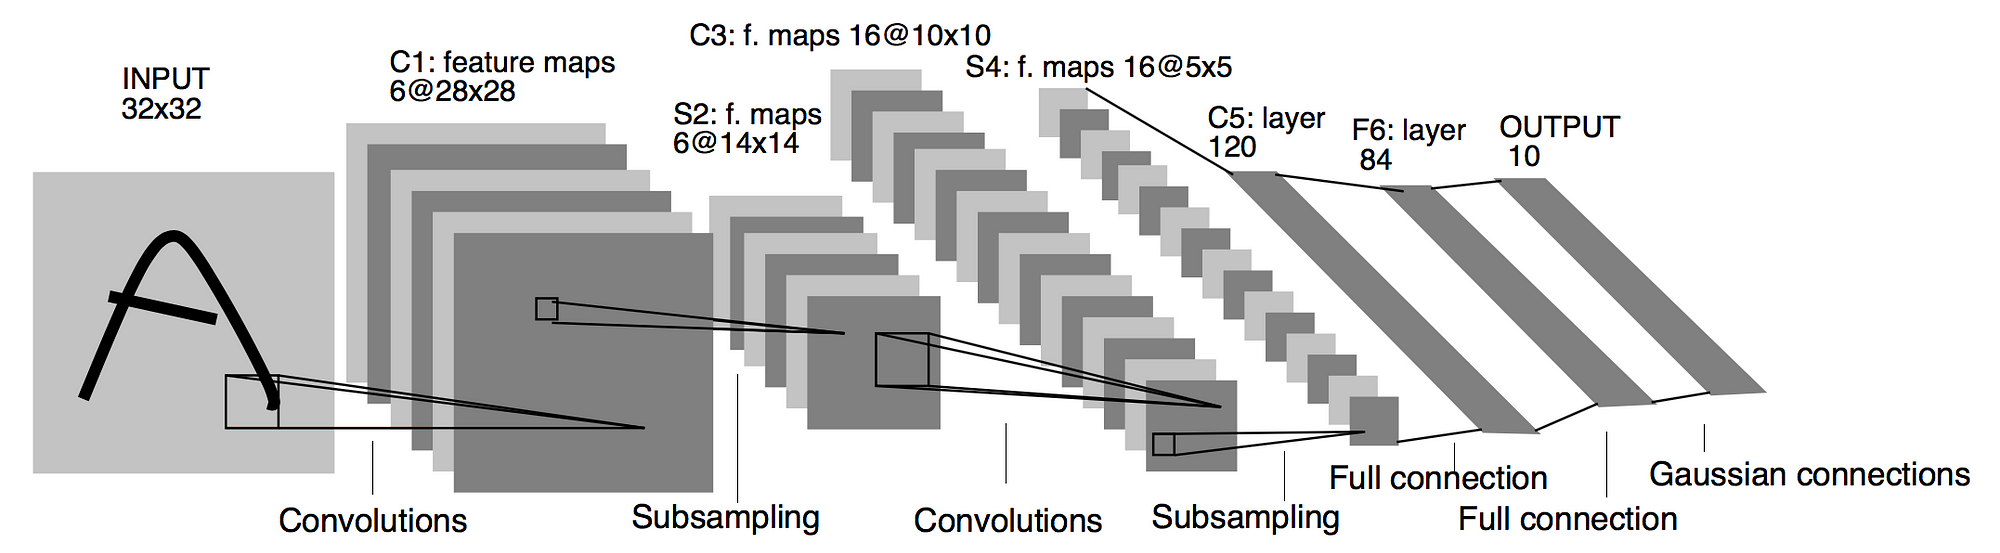

In [11]:
lenet = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(6, kernel_size=(5, 5), activation="tanh",padding='same'),
        layers.AveragePooling2D(pool_size=(2, 2),strides=(2,2)),
        layers.Conv2D(16, kernel_size=(5, 5), activation="tanh",padding='same'),
        layers.AveragePooling2D(pool_size=(2, 2),strides=(2,2)),
        layers.Conv2D(120, kernel_size=(5, 5), activation="tanh",padding='same'),
        layers.Flatten(),
        layers.Dense(84, activation="tanh"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

lenet.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 7, 7, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 84)             │       494,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,546 (2.08 MB)

 Trainable params: 545,546 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Finalmente entrenamos a las redes neuronales. Utilizaremos un tamaño de batch de 128 con 15 iteraciones o épocas. La función de costo usualmente es la de Entropía Cruzada Categórica con el optimizador Adam. Utilizamos el 10% de nuestros datos para hacer validación.

In [12]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15


I0000 00:00:1750554305.992573   15051 service.cc:152] XLA service 0x7c0ebc0074f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750554305.992591   15051 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-06-21 19:05:06.286210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750554306.714788   15051 cuda_dnn.cc:529] Loaded cuDNN version 90300


 90/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6201 - loss: 1.4024

I0000 00:00:1750554309.590403   15051 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8240 - loss: 0.6520 - val_accuracy: 0.9775 - val_loss: 0.0767
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0860 - val_accuracy: 0.9813 - val_loss: 0.0614
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9807 - loss: 0.0612 - val_accuracy: 0.9858 - val_loss: 0.0494
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9847 - loss: 0.0483 - val_accuracy: 0.9883 - val_loss: 0.0432
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9881 - loss: 0.0408 - val_accuracy: 0.9880 - val_loss: 0.0460
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9885 - loss: 0.0373 - val_accuracy: 0.9897 - val_loss: 0.0370
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9901 - loss: 0.0312 - val_accuracy: 0.9898 - val_loss: 0.0375
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9915 - loss: 0.0264 - val_accuracy: 0.9878 - val_

In [13]:
batch_size = 128
epochs = 15

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_2 = model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6166 - loss: 1.2001 - val_accuracy: 0.9540 - val_loss: 0.1638
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9141 - loss: 0.2791 - val_accuracy: 0.9720 - val_loss: 0.1038
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9383 - loss: 0.2014 - val_accuracy: 0.9773 - val_loss: 0.0821
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9482 - loss: 0.1711 - val_accuracy: 0.9797 - val_loss: 0.0691
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9539 - loss: 0.1493 - val_accuracy: 0.9810 - val_loss: 0.0648
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9575 - loss: 0.1394 - val_accuracy: 0.9847 - val_loss: 0.0565
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9626 - loss: 0.1237 - val_accuracy: 0.9848 - val_loss: 0.0521
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9648 - loss: 0.1111 - val_accuracy: 0.

In [14]:
batch_size = 32
epochs = 15

lenet.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

history_3 = lenet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15


2025-06-21 19:06:58.570207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_399', 84 bytes spill stores, 84 bytes spill loads

2025-06-21 19:06:58.715064: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_399', 8 bytes spill stores, 8 bytes spill loads

2025-06-21 19:06:58.794851: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_399', 8 bytes spill stores, 8 bytes spill loads



1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7733 - loss: 0.9161 - val_accuracy: 0.9342 - val_loss: 0.2280
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9223 - loss: 0.2606 - val_accuracy: 0.9545 - val_loss: 0.1664
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9418 - loss: 0.1976 - val_accuracy: 0.9617 - val_loss: 0.1378
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9521 - loss: 0.1631 - val_accuracy: 0.9682 - val_loss: 0.1191
Epoch 5/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9588 - loss: 0.1380 - val_accuracy: 0.9710 - val_loss: 0.1062
Epoch 6/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9638 - loss: 0.1253 - val_accuracy: 0.9710 - val_loss: 0.1001
Epoch 7/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9691 - loss: 0.1058 - val_accuracy: 0.9770 - val_loss: 0.0868
Epoch 8/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9713 - loss: 0.0992 - val_accurac

Finalmente podemos evaluar los modelos.



In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss model 1:", score[0])
print("Test accuracy model 1:", score[1])

Test loss model 1: 0.03429393470287323
Test accuracy model 1: 0.9900000095367432


In [16]:
score = model2.evaluate(X_test, y_test, verbose=0)
print("Test loss model 2:", score[0])
print("Test accuracy model 2:", score[1])

Test loss model 2: 0.044127482920885086
Test accuracy model 2: 0.9865000247955322


In [17]:
score = lenet.evaluate(X_test, y_test, verbose=0)
print("Test loss model 2:", score[0])
print("Test accuracy model 2:", score[1])

Test loss model 2: 0.06604381650686264
Test accuracy model 2: 0.9789999723434448


También podemos ver la evolución del entrenamiento de acuerdo con las épocas.

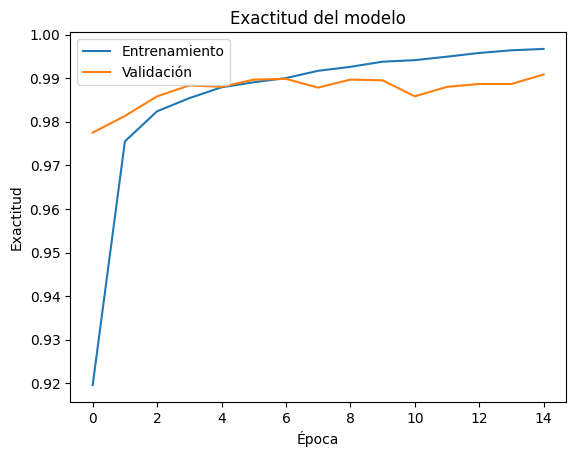

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

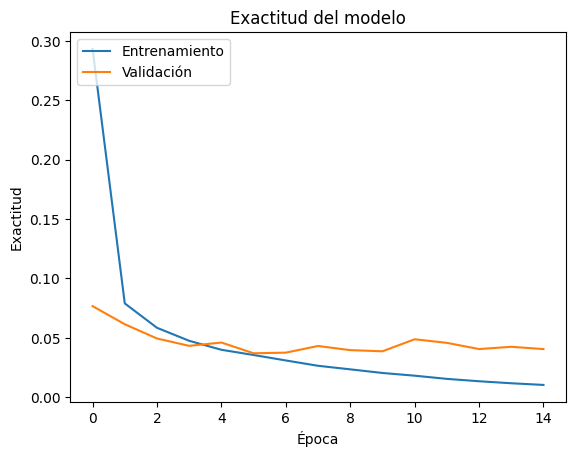

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

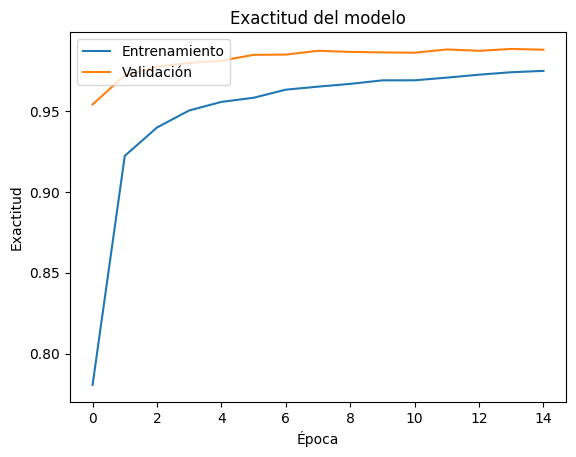

In [20]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

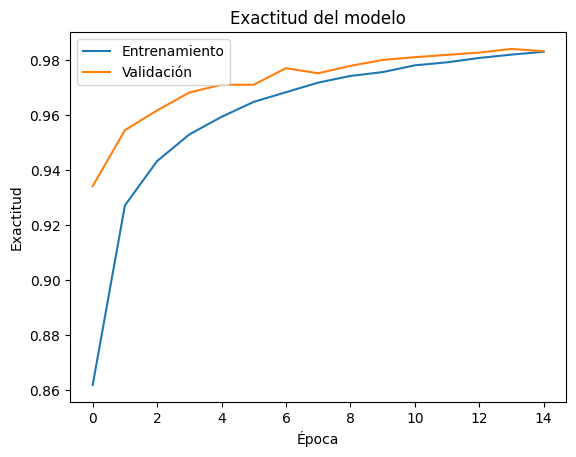

In [21]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

Finalmente, nos puede interesar usar el modelo. En este caso, requerimos hacer algunas operaciones. Para eso, leemos una imagen de un dígito manuscrito. Usaremos un uno que dibujé en Paint.

In [22]:
img = plt.imread('./datasets/mnist/cinco.png')

Ahora mostrarmos la imagen.

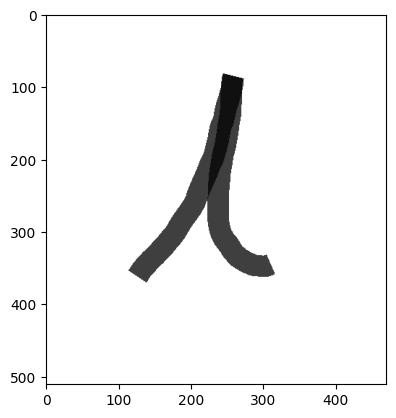

In [23]:
plt.imshow(img)

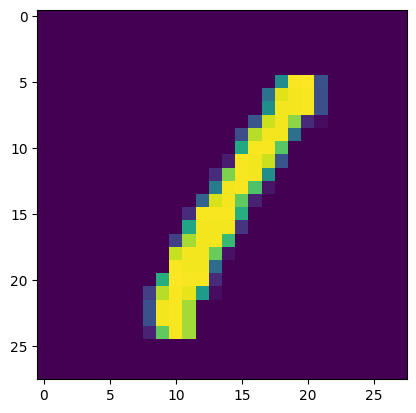

In [24]:
plt.imshow(X_train[3]*255)

Tenemos que escalar la imagen, convertirla a escala de grises, e invertir el color, utilizando OpenCV.

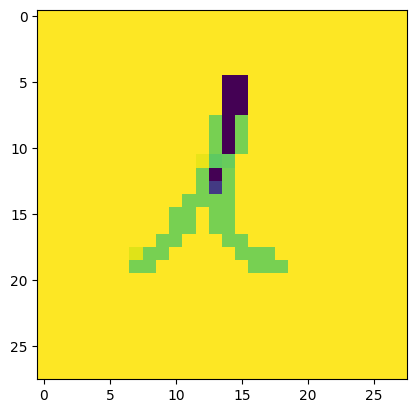

In [27]:
img = cv2.resize(img,(28,28))
img = cv2.bitwise_not(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

In [28]:
img = img / 255.

La imagen anterior ya se parece a las imágenes del MNIST, por lo que ya tiene sentido aplicar la red neuronal. Pero antes tenemos que ajustar a la dimensión de entrada. Es común añadir una dimensión al principio porque la red suele leer batches.

In [29]:
img = np.resize(img,(1,28,28,1))

Realizamos la predicción. La categoría está dada por el argmax de la salida.

In [30]:
prediccion = model.predict(img)
print(prediccion)
print(np.argmax(prediccion))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
[[0.07258006 0.17448    0.14544961 0.05914547 0.09173241 0.11046191
  0.12195589 0.10576469 0.05176041 0.06666954]]
1
